# Welcome to Receptiviti!

If this is your first time using the Receptiviti API - check out our [Getting Started guide](https://github.com/Receptiviti/api_tutorials_demos/blob/master/tutorials/python/Getting%20Started.ipynb)

SALLEE is Receptiviti's emotion and sentiment detection engine and is made available through the Receptiviti API. For more details on SALLEE, [check out our documentation here](https://dashboard.receptiviti.com/docs/sallee).

In this Jupyter Notebook, we will examine the emotional underpinnings of text gathered from a social media context i.e. Reddit. We will also find out how to batch a bulk request to the API i.e. send say 5 batches of 1000 texts to be scored by the Receptiviti API.

Play around with the code on this notebook, modify it to your liking and most importantly, have buckets of fun!

Let's begin with:

## Step 1 - Your API Keys
**Don't forget to add your API key and secret into the following cell**

In [282]:
API_KEY = ''
API_SECRET = ''

## Step 2 - Install python libraries

If you are running this notebook within a Google Colab environment, follow the instructions [here](#Option-1---Google-Colab). Google Colab provides all the requisite python libraries you will need to execute this Jupyter Notebook. 

If you are running this notebook locally or on your own server setup, determine if your system uses Conda or Pip to manage python dependencies. If you prefer Conda, follow the instructions [here](#Option-2---Conda) to install the requisite python libraries. If you prefer Pip, follow the instructions [here](#Option-3---Pip).

***Remember*** that you will only need to use either Conda ***or*** Pip to set up your python environment locally - not both. 

### Option 1 - Google Colab

Uncomment the cell below and run

In [279]:
#!pip install convokit

### Option 2 - Conda
Uncomment the cell below and run

In [277]:
# import sys
# !conda install --yes --prefix {sys.prefix} requests pandas numpy matplotlib convokit

### Option 3 - Pip
Uncomment the cell below and run

In [278]:
# import sys
# !{sys.executable} -m pip install requests pandas numpy matplotlib convokit

## Step 3 - Explore the dataset

We use the Cornell Conversational Toolkit library to examine a small corpus of Reddit data. This toolkit provides convenient access to conversational datasets that are out-of-the-box. In this Jupyter Notebook, we will examine a small reddit corpus, sampled from 100 active subreddits. 

For further details on `convokit`, check out their:

- **[Github](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit)**
- **[Documentation](https://convokit.cornell.edu/documentation/)**

In [280]:
from convokit import Corpus, download
corpus = Corpus(filename=download("reddit-corpus-small"))
corpus.print_summary_stats()
df = corpus.get_utterances_dataframe()

Dataset already exists at /Users/varshas/.convokit/downloads/reddit-corpus-small
Number of Speakers: 119889
Number of Utterances: 297132
Number of Conversations: 8286


### Step 3.1 - Filter the dataset for this tutorial

In this step, we will remove all text samples that have no usable text in them e.g. - they are empty or have been removed due to moderation or deleted for other reasons. 

Next, we will choose a set of 3 interesting subreddits to work with to facilitate a quick, but thorough tutorial. Here we choose - `r/canada`, `r/business` and `r/askscience`.

In [124]:
filtered_df = df[(df['text']!='') & (df['text']!='[removed]') & (df['text']!='[deleted]')]
print("Quick description of data")
grouping = filtered_df.groupby('meta.subreddit')['text'].describe().reset_index().sort_values(by='count', ascending=False)
display(grouping)
print("Let's choose 3 interesting but distinct subreddits")
subs = ['canada', 'business', 'askscience']
print("There are: \n{}".format(subs))
filtered_df = filtered_df[filtered_df['meta.subreddit'].isin(subs)]

Quick description of data


,meta.subreddit,count,unique,top,freq
74,pics,6722,6678,Yes,5
93,todayilearned,6645,6604,Yes,5
55,explainlikeimfive,6462,6426,Thanks!,5
98,worldnews,5200,5189,Yes.,3
97,videos,5141,5111,d,4
...,...,...,...,...,...
89,techsupport,1528,1523,yes,3
67,motorcycles,1518,1512,##NEW BIKE SUPERTHREAD! - a thread for questio...,4
81,rupaulsdragrace,1398,1386,Sasha's was okay compared to Alyssa. SKDKKKLLSKK,5
30,OkCupid,1348,1340,Got a sexy new pair of jeans? Unsure if your b...,4


Let's choose 3 interesting but distinct subreddits
There are: 
['canada', 'business', 'askscience']


### Step 3.2 - Attach a request id
It's generally good practice not to rely on the order of results returned by the API to match the order in which text samples are sent to the API for scoring. Amongst several advantages of using a token like a request id to keep track of which row generated which score is the ability to be thread safe and use multiprocessing to score multiple batches of text at once. We will demonstrate how to use this feature in the Receptiviti API below.

Let's start by attaching a column called `request_id` to the dataframe. We will see how this becomes useful in [Step 5](#Step-5.3---Join-scores-with-original-data)

In [125]:
from uuid import uuid4
filtered_df['request_id'] = filtered_df.apply(lambda _: str(uuid4()), axis=1)
print("Number of text samples: {}".format(filtered_df.shape))
display(filtered_df.head())

Number of text samples: (9399, 15)


,timestamp,text,speaker,reply_to,conversation_id,meta.score,meta.top_level_comment,meta.retrieved_on,meta.gilded,meta.gildings,meta.subreddit,meta.stickied,meta.permalink,meta.author_flair_text,request_id
id,,,,,,,,,,,,,,,
9e22yl,1536386234,The title says it all! Do you think his new pa...,RedarmRonny,None,9e22yl,2,None,1540093243,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9e22yl/what_do_you_think_of...,,5e27717b-1f32-46ac-9ec1-0770596b5225
9h1qla,1537328102,Aberfoyle is a small community outside of Guel...,ineedmoney17,None,9h1qla,96,None,1540143612,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9h1qla/can_rcanada_work_tog...,,5c136dd7-52a5-475a-be09-e58ea40eecf2
9hzbt5,1537619365,Even some countries that are significantly poo...,theusernameIhavepick,None,9hzbt5,1065,None,1540159386,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9hzbt5/why_does_canada_have...,,1552f288-d5a5-4492-95ac-0ffeda4eece8
9iwdc9,1537911518,You may not know about it (I barely ever see i...,expendablethoughts,None,9iwdc9,162,None,1540174815,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9iwdc9/extremely_low_unempl...,Québec,aa924abc-b5dc-4afe-99a6-4188c272228e
e56wrws,1535767534,Says a US-owned RW rag with zero cred,kudatah,9bz9c7,9bz9c7,-19,e56wrws,1538541908,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9bz9c7/np_view_the_credibil...,,b905b566-8c88-4945-bc22-dc4b78af8100


## Step 4 - Convert the scores into a table format

The Receptiviti API outputs a JSON object containing scores. In the cell below, we convert this JSON object into a table format using Python library [pandas](http://pandas.pydata.org/). Once converted into a table format or a dataframe, as it is commonly known, it becomes easier to read and digest.

In [126]:
import pandas as pd

def convert_sallee_to_table(results):
    sallee_scores = []
    if len(results)>0:
        for result in results['results']:
            request_id = result['request_id']
            if 'sallee' in result:
                # Pull out sallee scores
                sallee = {'sallee_' + k: float(v) for k,v in result['sallee']['scores']['emotions'].items()}
                sallee.update({'sallee_' + k: float(v) for k,v in result['sallee']['scores'].items() if k!='emotions'})
                sallee.update({'summary_'+k:v for k,v in result['summary'].items()})
                sallee.update({'request_id': request_id})
                sallee_scores.append(sallee)
    return pd.DataFrame(sallee_scores)


## Step 5 - Completing a bulk request

### Step 5.1 - An unsuccessful bulk request
The bulk request payload size limit is set at 10MB. Anything exceeding that will result in an error and no scores will be returned. For the sake of demonstration, we have chosen to send the entire dataframe from [Step 3](#Step-3---Explore-the-dataset) as part of the payload. Let's see what the output looks like.

Start by creating an API helper function to handle a bulk request.

In [71]:
import json
import requests

def get_bulk_payload(texts, request_ids):
    return [{
            "content": text,
            "request_id": request_id
        } for text, request_id in zip(texts, request_ids)]


BULK_API_URL = 'https://api.receptiviti.com/v1/sallee/bulk'
payload = get_bulk_payload(filtered_df['text'], filtered_df['request_id'])
response = requests.post(BULK_API_URL, data=json.dumps(payload), auth=(API_KEY, API_SECRET), headers = {'Content-Type': 'application/json'})
bulk_results = []
if response.status_code==200:
    bulk_results = response.json()
else:
    print("Error code: {}".format(response.status_code))
    print("HTTP status code 413 is a top level error signalling that the request body exceeded 10MB and that this call will not count towards our plan")
    print("You can find more details here - https://dashboard.receptiviti.com/docs/api")

Error code: 413
HTTP status code 413 is a top level error signalling that the request body exceeded 10MB and that this call will not count towards our plan
You can find more details here - https://dashboard.receptiviti.com/docs/api


### Step 5.2 - Batching a bulk request
#### A successful bulk request

Scoring the entire dataframe from [Step 3](#Step-3---Explore-the-dataset) at once was unsuccessful because the Receptiviti API restricts each bulk request payload to be under 10MB. We fix that in this next section by batch scoring chunks of text from the dataframe. 

Let's start by creating a few helper functions. 

In [128]:
import json 
import requests
import numpy as np

MAX_PAYLOAD_SIZE = 25

def get_bulk_payload(texts, request_ids):
    return [{
            "content": text,
            "request_id": request_id
        } for text, request_id in zip(texts, request_ids)]

def batch_bulk_request(df, max_n):
    df_split = np.array_split(df, max_n)
    sallee_results_df = pd.DataFrame()
    n = len(df_split)
    for idx, df_portion in enumerate(df_split):
        BULK_API_URL = 'https://api.receptiviti.com/v1/sallee/bulk'
        payload = get_bulk_payload(df_portion['text'], df_portion['request_id'])
        response = requests.post(BULK_API_URL, data=json.dumps(payload), auth=(API_KEY, API_SECRET), headers = {'Content-Type': 'application/json'})
        bulk_results = []
        if response.status_code==200:
            bulk_results = response.json()
            results_df = convert_sallee_to_table(bulk_results)
            sallee_results_df = pd.concat([sallee_results_df, results_df])
        else:
            print("Error code: {}".format(response.status_code))
        print("Completed {}/{}".format(idx+1, n))
    return sallee_results_df

In [283]:
sallee_results_df = batch_bulk_request(filtered_df, MAX_PAYLOAD_SIZE)
display(sallee_results_df.head())

Completed 1/25
Completed 2/25
Completed 3/25
Completed 4/25
Completed 5/25
Completed 6/25
Completed 7/25
Completed 8/25
Completed 9/25
Completed 10/25
Completed 11/25
Completed 12/25
Completed 13/25
Completed 14/25
Completed 15/25
Completed 16/25
Completed 17/25
Completed 18/25
Completed 19/25
Completed 20/25
Completed 21/25
Completed 22/25
Completed 23/25
Completed 24/25
Completed 25/25


,sallee_admiration,sallee_amusement,sallee_anger,sallee_boredom,sallee_calmness,sallee_curiosity,sallee_desire,sallee_disgust,sallee_excitement,sallee_fear,...,sallee_non_emotion,summary_word_count,summary_words_per_sentence,summary_sentence_count,summary_six_plus_words,summary_emojis,summary_emoticons,summary_hashtags,summary_urls,request_id
0,0.251166,0.0,0.000000,0.0,0.0,0.0,0.0,0.358570,0.075458,0.00000,...,0.713110,31,7.750000,4,0.290323,0.0,0.0,0.00000,0.000000,5e27717b-1f32-46ac-9ec1-0770596b5225
1,0.458040,0.0,0.077929,0.0,0.0,0.0,0.0,0.000000,0.336471,0.00000,...,0.803279,160,22.857143,7,0.356250,0.0,0.0,0.01875,0.000000,5c136dd7-52a5-475a-be09-e58ea40eecf2
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.114338,0.000000,0.00000,...,0.722222,29,9.666667,3,0.206897,0.0,0.0,0.00000,0.000000,1552f288-d5a5-4492-95ac-0ffeda4eece8
3,0.491628,0.0,0.257284,0.0,0.0,0.0,0.0,0.103517,0.054584,0.59073,...,0.871387,438,29.200000,15,0.244292,0.0,0.0,0.00000,0.002283,aa924abc-b5dc-4afe-99a6-4188c272228e
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.182744,0.000000,0.00000,...,0.888889,9,9.000000,1,0.000000,0.0,0.0,0.00000,0.000000,b905b566-8c88-4945-bc22-dc4b78af8100


### Step 5.3 - Join scores with original data

When it's time to do analysis with the scores, it's great to have the metadata from the original dataset also be present along with the scores. This allows us to examine score differences across different groups. E.g., here, we could look at SALLEE `curiosity` scores across various subreddits (column `meta.subreddit`).

Let's complete the join and look at some descriptive statistics across various `subreddits` and `speakers`.

In [284]:
merged_sallee_results_df = sallee_results_df.merge(filtered_df, on='request_id')
print("SALLEE scores merged with original dataset")
display(merged_sallee_results_df.head())

SALLEE scores merged with original dataset


,sallee_admiration,sallee_amusement,sallee_anger,sallee_boredom,sallee_calmness,sallee_curiosity,sallee_desire,sallee_disgust,sallee_excitement,sallee_fear,...,conversation_id,meta.score,meta.top_level_comment,meta.retrieved_on,meta.gilded,meta.gildings,meta.subreddit,meta.stickied,meta.permalink,meta.author_flair_text
0,0.251166,0.0,0.000000,0.0,0.0,0.0,0.0,0.358570,0.075458,0.00000,...,9e22yl,2,None,1540093243,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9e22yl/what_do_you_think_of...,
1,0.458040,0.0,0.077929,0.0,0.0,0.0,0.0,0.000000,0.336471,0.00000,...,9h1qla,96,None,1540143612,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9h1qla/can_rcanada_work_tog...,
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.114338,0.000000,0.00000,...,9hzbt5,1065,None,1540159386,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9hzbt5/why_does_canada_have...,
3,0.491628,0.0,0.257284,0.0,0.0,0.0,0.0,0.103517,0.054584,0.59073,...,9iwdc9,162,None,1540174815,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9iwdc9/extremely_low_unempl...,Québec
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.182744,0.000000,0.00000,...,9bz9c7,-19,e56wrws,1538541908,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9bz9c7/np_view_the_credibil...,


## Step 6 - Examine SALLEE scores by subreddit

In this section, we will examine positive, neutral and negative SALLEE scores i.e. emotions across the 3 subreddits [we chose earlier here](#Step-3.1---Filter-the-dataset-for-this-tutorial). This is not meant to be a statistical exmaintion of group differences, rather a visual that supports our intuition about the contents of the subreddits.

Let's start by massaging the dataframe with SALLEE scores and metadata from [here](#Step-5.3---Join-scores-with-original-data) into a form that can be easily plotted. 

In [271]:
sallee_score_columns = ['sallee_'+s for s in ['love', 'joy', 'amusement', 'gratitude', 'admiration', 'calmness', 
                                             'excitement', 'desire', 'curiosity', 'surprise','pain', 'boredom', 'sadness',
                                             'disgust', 'fear', 'anger']]
grouped = pd.pivot_table(merged_sallee_results_df, values=sallee_score_columns, index=['meta.subreddit'],
                    aggfunc=np.mean).stack().reset_index()
grouped.columns=['meta.subreddit', 'sallee_score', 'score']
grouped = grouped.pivot(columns='meta.subreddit', index='sallee_score', values='score')
display(grouped)

meta.subreddit,askscience,business,canada
sallee_score,,,
sallee_admiration,0.101751,0.104884,0.085583
sallee_amusement,0.007465,0.020980,0.021473
sallee_anger,0.129090,0.159436,0.220810
sallee_boredom,0.011603,0.016954,0.014922
sallee_calmness,0.041978,0.030901,0.034383
sallee_curiosity,0.040928,0.027686,0.023183
sallee_desire,0.024135,0.038861,0.042482
sallee_disgust,0.067978,0.113874,0.129344
sallee_excitement,0.052029,0.035337,0.034535


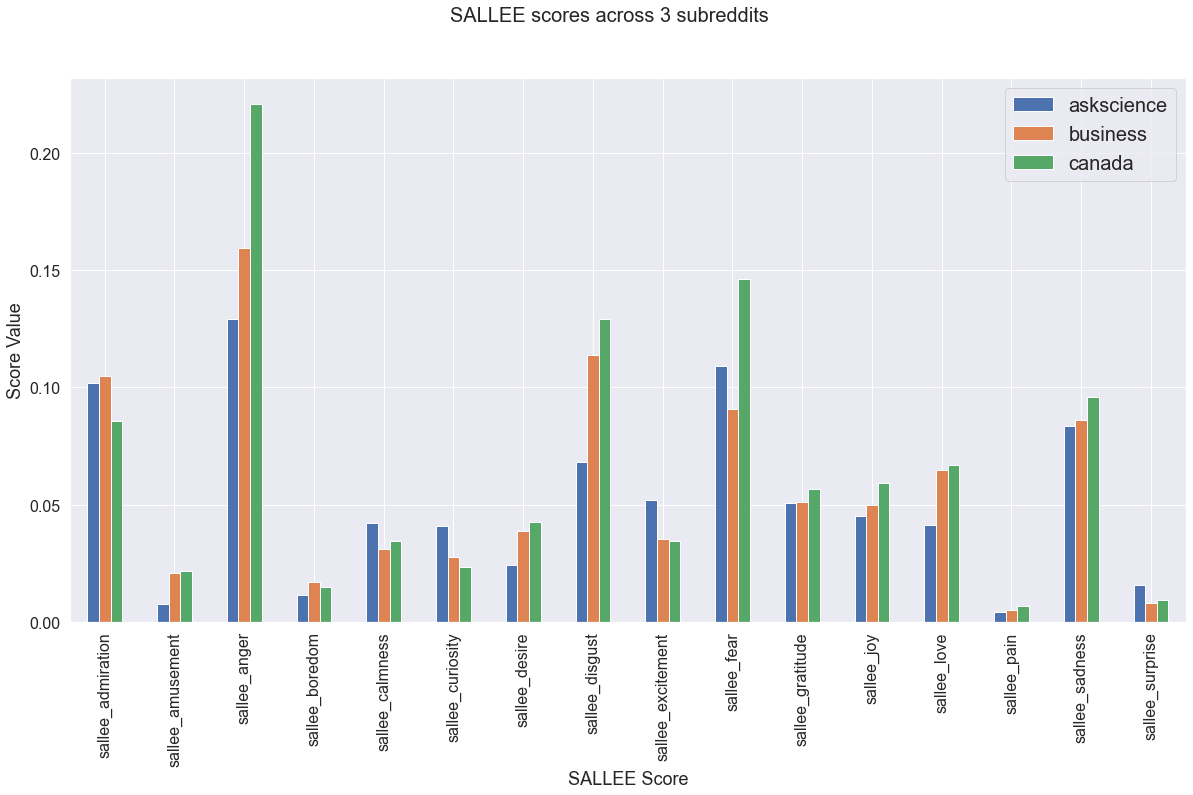

In [274]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
g = grouped.plot.bar(ax=ax, rot=90, fontsize=16)
fig.suptitle('SALLEE scores across 3 subreddits', fontsize=20)
_ = plt.xlabel('SALLEE Score', fontsize=18)
_ = plt.ylabel('Score Value', fontsize=18)
_ = plt.legend(prop={'size': 20})

- [`r/askscience`](https://www.reddit.com/r/askscience/) is a forum to answer science questions and promote science literacy. 
- [`r/business`](https://www.reddit.com/r/business/) typically contains article posts about companies and business news.
- [`r/canada`](https://www.reddit.com/r/canada/) is a subreddit about Canada containing both political and non-political content about the country at a national scale. 

With that introduction, in the graph above, we see the following:

- Anger is lowest in `r/askscience` and highest in `r/canada` 
- whereas Curiosity follows the opposite trend - highest in `r/askscience` and lowest in `r/canada`
- Disgust is lower in `r/askscience` than in `r/business` or `r/canada`